# Languages in the corpus

For later analysis, the language of texts is of importance. We therefore need statistics of the languages, to later focus on english and german texts. 

In [1]:
import pandas as pd
import datetime
import os
import re
import random
import numpy as np
from tqdm import tqdm
from functools import partial
from multiprocessing import  Pool, cpu_count

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

## Setup paths

In [2]:
yearBasePath = '/media/arbeit/b88b17b8-b5d7-4c4e-86bc-ff4b67458842/sciGraph/processedData/yeardata/'

In [3]:
yearLinkData = sorted([x for x in os.listdir(yearBasePath) if x.endswith('csv')])

In [4]:
def getNAuthors(row):
    if row:
        return len(row.split(';'))
    else:
        return 0

In [5]:
res = []
for year in tqdm(yearLinkData):
    try:
        dfTemp = pd.read_csv(yearBasePath + year,sep='\t',header=None, low_memory=False)
        dfTemp = dfTemp.rename(columns={0:'year',1:'publicationID',2:'title',3:'language',4:'journalID',5:'journal',6:'hasMPG',7:'authors',8:'affiliation'})
        dfLang = dfTemp.language.value_counts().to_frame().reset_index()
        langCounts = dfLang[dfLang["index"].isin(["['en']", "['de']","['fr']","['it']","['nl']","['ru']"])].set_index('index').to_dict()['language']
        langCounts.update(
            {'year': dfTemp.year.unique()[0],
             'N_pub':dfTemp.shape[0],
             'N_no_aut':dfTemp[dfTemp['authors'].isna()].shape[0],
             'N_no_aff':dfTemp[dfTemp['affiliation'].isna()].shape[0],
             'median authors':dfTemp.authors.fillna('').apply(lambda row: getNAuthors(row)).median() 
            })
        res.append(langCounts)
    except pd.errors.ParserError:
        print(year)
    

100%|██████████| 189/189 [02:00<00:00,  1.57it/s]


In [6]:
df = pd.DataFrame(res)

In [7]:
df.shape

(189, 11)

In [8]:
other = df.fillna(0).apply(lambda row: row['N_pub'] - row["['en']"] - row["['de']"] - row["['ru']"] - row["['fr']"] - row["['it']"],axis=1)

In [9]:
notDeEng = df.fillna(0).apply(lambda row: row['N_pub'] - row["['en']"] - row["['de']"],axis=1)

In [10]:
df.insert(0,'other',other)
df.insert(0,'not_de/eng',notDeEng)

In [11]:
df = df.set_index('year')

In [12]:
df.head(3)

not_de/eng    other  ['en']   N_pub  N_no_aut  N_no_aff  median authors  \
year                                                                            
1832         0.0      0.0      50      50        10        42             1.0   
1833         0.0      0.0      62      62        16        54             1.0   
1834         1.0      1.0      55      56        14        43             1.0   
1835         3.0      2.0      59      62        14        54             1.0   
1836         6.0      3.0      56      62        12        46             1.0   
...          ...      ...     ...     ...       ...       ...             ...   
2016     24105.0  19819.0  436896  486830     27854     50266             4.0   
2017     30052.0  24435.0  551611  610996     36302     60672             4.0   
2018     30017.0  25263.0  633293  694995     39056     80009             4.0   
2019      5821.0   4942.0  285185  302938      9249     45126             4.0   
NaN          1.0      1.0      44      45         6        33             3.0   

      ['fr']  ['it']   ['de']  ['nl']  ['ru']  
year                                           
1832     NaN     NaN      NaN     NaN     NaN  
1833     NaN     NaN      NaN     NaN     NaN  
1834     NaN     NaN      NaN     NaN     NaN  
1835     1.0     NaN      NaN     NaN     NaN  
1836     NaN     3.0      NaN     NaN     NaN  
...      ...     ...      ...     ...     ...  
2016  1683.0  2596.0  25829.0  7609.0     7.0  
2017  1902.0  3704.0  29333.0  7410.0    11.0  
2018   967.0  3778.0  31685.0  7073.0     9.0  
2019   210.0   665.0  11932.0  1482.0     4.0  
NaN      NaN     NaN      NaN     NaN     NaN  

[189 rows x 12 columns]

## Plots

What is the temporal distribution of languages other then english in the corpus?

  - The rise of netherlands language after 1996 is due to miss-detection of english short texts like book presentations in e.g. Nature.
  - The same might be true for italian.

/home/arbeit/Dokumente/gwdgGitlab/GMPG/gmpg-notebooks/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


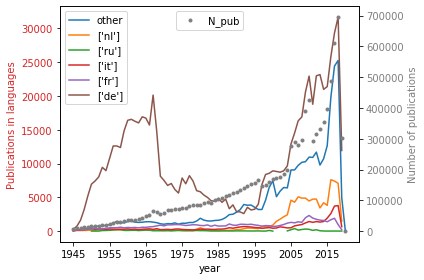

In [13]:
with PdfPages('../results/Fig2_MinorLanguages.pdf') as pdffigure:
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('year')
    ax1.set_ylabel('Publications in languages', color=color)
    plt1 = df.iloc[113:][['other',"['nl']","['ru']","['it']","['fr']","['de']"]].plot(ax=ax1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  
    ax1.legend(loc=0)
    color = 'tab:gray'
    ax2.set_ylabel('Number of publications', color=color)  
    plt2 = df.iloc[113:][['N_pub']].plot(ax=ax2,color=color, style='.')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc=9)

    fig.tight_layout()  
    pdffigure.savefig(bbox_inches="tight", dpi=400)
    plt.show()
    plt.close()

Compare contribution of german to english texts in the corpus, with all other languages as addition.

/home/arbeit/Dokumente/gwdgGitlab/GMPG/gmpg-notebooks/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


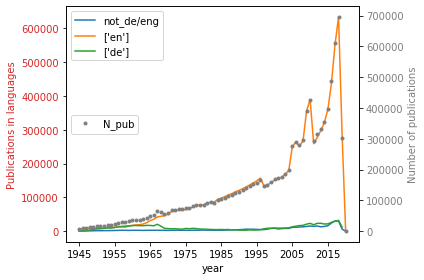

In [14]:
with PdfPages('../results/Fig3_MajorLanguages.pdf') as pdffigure:
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('year')
    ax1.set_ylabel('Publications in languages', color=color)
    plt1 = df.iloc[113:][['not_de/eng',"['en']","['de']"]].plot(ax=ax1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  
    ax1.legend(loc=0)
    color = 'tab:gray'
    ax2.set_ylabel('Number of publications', color=color)  
    plt2 = df.iloc[113:][['N_pub']].plot(ax=ax2,color=color, style='.')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc=6)

    fig.tight_layout()
    pdffigure.savefig(bbox_inches="tight", dpi=400)
    plt.show()
    plt.close()

/home/arbeit/Dokumente/gwdgGitlab/GMPG/gmpg-notebooks/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


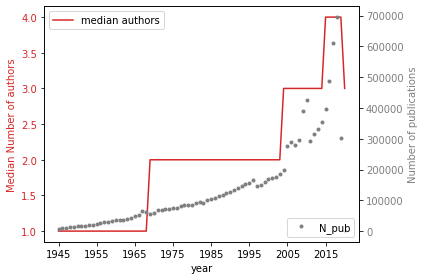

In [15]:
with PdfPages('../results/Fig4_MedianNAuthors.pdf') as pdffigure:
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('year')
    ax1.set_ylabel('Median Number of authors', color=color)
    plt1 = df.iloc[113:][['median authors']].plot(ax=ax1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  
    ax1.legend(loc=0)
    color = 'tab:gray'
    ax2.set_ylabel('Number of publications', color=color) 
    plt2 = df.iloc[113:][['N_pub']].plot(ax=ax2,color=color, style='.')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc=4)

    fig.tight_layout()  
    pdffigure.savefig(bbox_inches="tight", dpi=400)
    plt.show()
    plt.close()